In [1]:
import tensorflow as tf
from glob import glob
import unet
import matplotlib.pyplot as plt
import numpy as np
import Augmentor
print('Tensorflow', tf.__version__)

Tensorflow 2.0.0-beta0


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [3]:
image_list = sorted(glob('dataset/train_images/*'))
mask_list = sorted(glob('dataset/2_channel_mask/*'))
print('Found {} images \nFound {} masks'.format(len(image_list), len(mask_list)))

Found 2975 images 
Found 2975 masks


In [4]:
def imshow(img, mask):
    img = tf.io.read_file(img)
    img = tf.image.decode_image(img, channels=3)
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(1,2,1)
    ax.set_title('Image')
    ax.axis('off')
    ax.imshow(img)
    
    mask = tf.io.read_file(mask)
    mask = tf.image.decode_image(mask, channels=1)
    ax = fig.add_subplot(1,2,2)
    ax.set_title('Mask')
    ax.axis('off')
    ax.imshow(np.squeeze(mask))

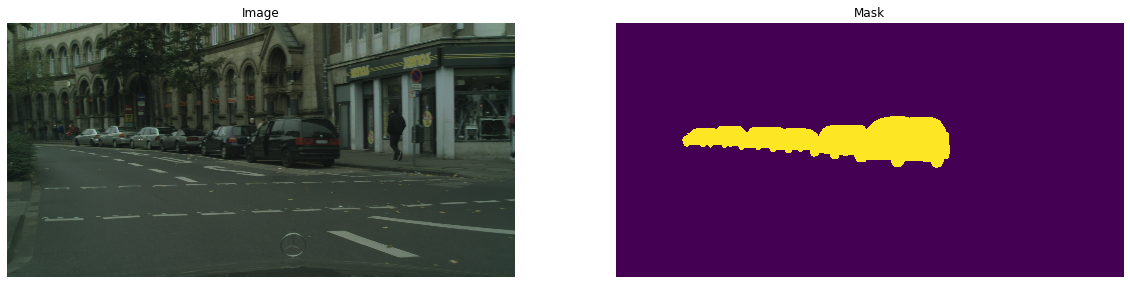

In [5]:
imshow(image_list[100], mask_list[100])

In [6]:
H, W = 512, 512
batch_size = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
aug = glob('dataset/augmented_img/*')

In [8]:
def get_image(path, mask=False):
    img = tf.io.read_file(path)
    if not mask:
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size=[H, W])
        img /= 255.
    else:
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, size=[H, W]) > 0
        img = tf.cast(img, tf.float32)
    return img

def load_data(image_path, mask_path):
    return get_image(image_path), get_image(mask_path, mask=True)

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((aug, mask_list))
train_ds = train_ds.shuffle(256)
train_ds = train_ds.map(load_data, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(AUTOTUNE)

In [10]:
print(train_ds)

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [11]:
def dice_loss(pred, actual):
    num = 2 * tf.reduce_sum((pred * actual), axis=-1)
    den = tf.reduce_sum((pred + actual), axis=-1)
    return 1 - (num + 1) / (den + 1)

In [12]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    model = unet.model(512, 512, 1)
    model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), 
                  loss = dice_loss, 
                  metrics = ['accuracy'])

Loading UNET


In [ ]:
history = model.fit(train_ds, epochs=5, steps_per_epoch=len(image_list)//batch_size)

In [15]:
model.save_weights('weights.h5')